# 下载数据

根据下载链接，使用selenium下载数据。

In [ ]:
import os
import time
import shutil
import datetime
from selenium import webdriver

def download(
        url_list:list[str],
        save_dir:str
    ):
    """根据下载链接列表, 下载文件到指定文件夹"""
    
    # 打开浏览器
    chromeOptions = webdriver.ChromeOptions()
    prefs = {"download.default_directory": save_dir}
    chromeOptions.add_experimental_option("prefs", prefs)
    driver = webdriver.Chrome(options=chromeOptions)

    # 下载文件
    for url in url_list:
        file_name = os.path.basename(url)
        save_path = os.path.join(save_dir, file_name)

        if os.path.exists(save_path): continue

        driver.get(url)
        time.sleep(1)

        while 1:
            if os.path.exists(save_path): break
            time.sleep(1)

        print(f"Download {file_name} success!")

if __name__ == "__main__":
    # 下载链接列表
    urlList = []
    startTime = datetime.datetime(2010, 5, 1, 0, 0, 0)
    endTime = datetime.datetime(2025, 1, 1, 0, 0, 0)
    indexTime = startTime
    while indexTime < endTime:
        urlList.append(indexTime.strftime("https://jsoc1.stanford.edu/data/hmi/fits/%Y/%m/%d/hmi.M_720s.%Y%m%d_%H%M%S_TAI.fits"))
        indexTime += datetime.timedelta(days=1)

    # 保存路径 -- 要求为绝对路径
    saveDir = "D:\\Flare_Predicting\\data\\SDO"

    # 下载文件
    download(urlList, saveDir)

# 磁场数据可视化

读取fits文件中的磁场数据进行可视化。

In [ ]:
import os
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

def fitsVisualize(fitsPath, jpgPath):
    if os.path.exists(jpgPath): return
    os.makedirs(os.path.dirname(jpgPath), exist_ok=True)
    try:
        hduList = fits.open(fitsPath)
        data = hduList[1].data
        data = np.nan_to_num(data)
        hduList.close()
        plt.figure()
        plt.axis('off')
        plt.imshow(np.stack([data]*3, axis=-1), cmap='gray')
        plt.tight_layout(pad=0)
        plt.savefig(jpgPath, bbox_inches='tight', pad_inches=0)
        plt.close()
    except:
        print(f'{fitsPath}可视化失败。')

if __name__ == '__main__':
    fitsFolder = "./fits"

    for root, dirs, files in os.walk(fitsFolder):
        for file in files:
            if file.endswith(".fits"):
                fitsFile = os.path.join(root, file)
                jpgFile = fitsFile.replace("fits", "jpg")
                fitsVisualize(fitsFile, jpgFile)

# 数据预处理

对磁场数据进行裁剪、放缩、保存等操作。

In [ ]:
import os
import cv2
import numpy as np
from astropy.io import fits

def crop(data):
    """裁剪四周的缺失值"""
    h, w = data.shape
    left = 0; right = w-1
    while left < w and np.all(np.isnan(data[:, left])): left += 1
    while right >= 0 and np.all(np.isnan(data[:, right])): right -= 1
    top = 0; bottom = h-1
    while top < h and np.all(np.isnan(data[top, :])): top += 1
    while bottom >= 0 and np.all(np.isnan(data[bottom, :])): bottom -= 1
    return np.nan_to_num(data[top:bottom+1, left:right+1])

def preprocess(fitsPath, npzPath):
    if os.path.exists(npzPath): return
    os.makedirs(os.path.dirname(npzPath), exist_ok=True)
    try:
        hdulist = fits.open(fitsPath)
        data = hdulist[1].data
        hdulist.close()
        cropped = crop(data)
        resized = cv2.resize(cropped, (512, 512), interpolation=cv2.INTER_LINEAR)
        np.savez_compressed(npzPath, data = resized)
    except:
        print(f'{fitsPath}预处理失败。')

if __name__ == "__main__":
    fitsFolder = "./waste/fits"
    for root, dirs, files in os.walk(fitsFolder):
        for file in files:
            if file.endswith(".fits"):
                fitsFile = os.path.join(root, file)
                npzFile = fitsFile.replace("fits", "npz")
                preprocess(fitsFile, npzFile)

# 数据增强可视化

随机旋转、水平翻转、竖直翻转三种数据增强的可视化。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1625.8559479713442..1243.025670051575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1625.8559479713442..1243.025670051575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1625.8559479713442..1243.025670051575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1625.8559479713442..1243.025670051575].


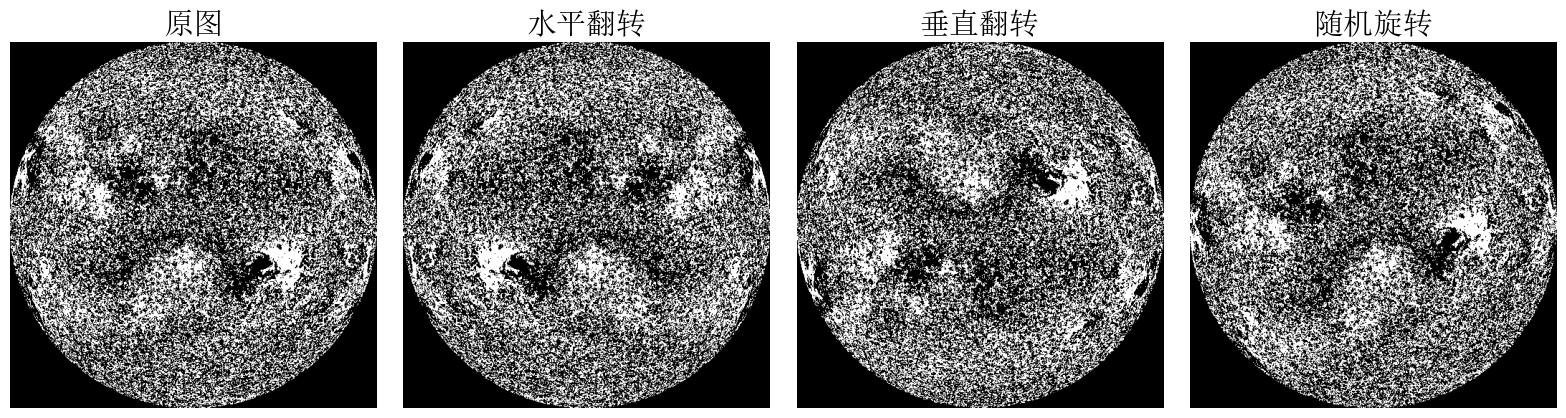

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 18,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt


dataPath = r'npz\2023\7\1\hmi.M_720s.20230701_000000_TAI.npz'
data = np.load(dataPath)['data']

# 数据增强1: 随机旋转
rotation = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=25)])

# 数据增强2: 水平翻转
hrFlip = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=1.0)])

# 数据增强3：垂直翻转
vrFlip = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=1.0)])

rotateData = rotation(data).numpy().squeeze()
hrFlipData = hrFlip(data).numpy().squeeze()
vrFlipData = vrFlip(data).numpy().squeeze()

# 可视化
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.imshow(np.stack([data]*3, axis=-1), cmap='gray')
plt.axis('off')
plt.title('原图')
plt.subplot(1, 4, 2)
plt.imshow(np.stack([hrFlipData]*3, axis=-1), cmap='gray')
plt.axis('off')
plt.title('水平翻转')
plt.subplot(1, 4, 3)
plt.imshow(np.stack([vrFlipData]*3, axis=-1), cmap='gray')
plt.axis('off')
plt.title('垂直翻转')
plt.subplot(1, 4, 4)
plt.imshow(np.stack([rotateData]*3, axis=-1), cmap='gray')
plt.axis('off')
plt.title('随机旋转')

plt.tight_layout()
plt.savefig('数据增强.png', dpi=600, bbox_inches='tight')
plt.show()
